In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas

In [ ]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math


from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#tf.__version__

## Parte 1 - Importação do Dataset e Estatística Descritiva

In [ ]:
# Importação da Base de Dados
#dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_GE-4100_12001B.csv')
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4451_08001A.csv')

# Eliminando as TAGs que não se referem aos mancais do equipamento
#dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCD.F_CV']
#dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCT.F_CV']

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2245 entries, 0 to 2244
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EQUIPAMENTO  2245 non-null   object 
 1   MANCAL       2245 non-null   object 
 2   DATA         2245 non-null   object 
 3   TEMPERATURA  2245 non-null   float64
dtypes: float64(1), object(3)
memory usage: 70.3+ KB


In [ ]:
dataset.head()

,EQUIPAMENTO,MANCAL,DATA,TEMPERATURA
0,C-4451.08001A,EJA1.A-TC21.F_CV,04/01/2021,69.88962
1,C-4451.08001A,EJA1.A-TC21.F_CV,05/01/2021,69.59235
2,C-4451.08001A,EJA1.A-TC21.F_CV,06/01/2021,69.56962
3,C-4451.08001A,EJA1.A-TC21.F_CV,07/01/2021,67.57046
4,C-4451.08001A,EJA1.A-TC21.F_CV,15/01/2021,69.05307


In [ ]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2245 entries, 0 to 2244
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   EQUIPAMENTO  2245 non-null   object        
 1   MANCAL       2245 non-null   object        
 2   DATA         2245 non-null   datetime64[ns]
 3   TEMPERATURA  2245 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 87.7+ KB


In [ ]:
dataset.groupby(['EQUIPAMENTO','MANCAL']).count()

DATA  TEMPERATURA
EQUIPAMENTO   MANCAL                                
C-4451.08001A EJA1.A-TC21.F_CV      132          132
              EJA1.A-TC22.F_CV      132          132
              EJA1.A-TC23.F_CV      132          132
              EJA1.A-TC25.F_CV      132          132
              EJA1.A-TC250.F_CV     133          133
              EJA1.A-TC251.F_CV     132          132
              EJA1.A-TC26.F_CV      132          132
              EJA1.A-TC27.F_CV      132          132
              EJA1.A-TC28.F_CV      132          132
              EJA1.A-TE1200A.F_CV   132          132
              EJA1.A-TE1200B.F_CV   132          132
              EJA1.A-TE1203A.F_CV   132          132
              EJA1.A-TE1203B.F_CV   132          132
              EJA1.A-TE1206A.F_CV   132          132
              EJA1.A-TE1206B.F_CV   132          132
              EJA1.A-TE1209A.F_CV   132          132
              EJA1.A-TE1209B.F_CV   132          132

In [ ]:
#Separação do dataset por mancais
mancais = dataset['MANCAL'].unique().tolist()

manc1 = dataset[dataset['MANCAL'] == mancais[0]]
manc2 = dataset[dataset['MANCAL'] == mancais[1]]
manc3 = dataset[dataset['MANCAL'] == mancais[2]]
manc4 = dataset[dataset['MANCAL'] == mancais[3]]
manc5 = dataset[dataset['MANCAL'] == mancais[4]]
manc6 = dataset[dataset['MANCAL'] == mancais[5]]
manc7 = dataset[dataset['MANCAL'] == mancais[6]]

#Criação do dataframe com as datas registradas para pelo menos um dos mancais
lista_datas = dataset['DATA'].unique().tolist()
datas_registradas = pd.DataFrame(lista_datas,columns=['DATA'])
datas_registradas['DATA'] = pd.to_datetime(datas_registradas['DATA'],dayfirst=True)


In [ ]:
# Ajuste dos datasets para incluir datas faltantes do conjunto e preencher os 
# dados faltantes. A temperatura será preenchida com a moda do conjunto de 
# temperaturas do mancal.
def completeDates( dates, dataset ):
  result = pd.merge(dates, dataset, on='DATA', how='outer')
  result['EQUIPAMENTO'].fillna(np.array(dataset['EQUIPAMENTO'])[0], inplace = True);
  result['MANCAL'].fillna(np.array(dataset['MANCAL'])[0], inplace = True);
  result['TEMPERATURA'].fillna(np.array(manc3['TEMPERATURA'].mode())[0], inplace = True)
  return result

#manc1 = completeDates( datas_registradas, manc1)
#manc1 = completeDates( datas_registradas, manc2)
#manc3 = completeDates( datas_registradas, manc3)
#manc4 = completeDates( datas_registradas, manc4)
#manc5 = completeDates( datas_registradas, manc5)
#manc6 = completeDates( datas_registradas, manc6)
#manc7 = completeDates( datas_registradas, manc7)

In [ ]:
dataset.describe()

,TEMPERATURA
count,2245.000000
mean,64.265038
std,16.315631
min,18.718320
25%,54.898560
50%,59.504080
75%,71.582280
max,390.441750


#### Análise Gráfica

No handles with labels found to put in legend.


Text(0.5, 0, 'Temperatura')

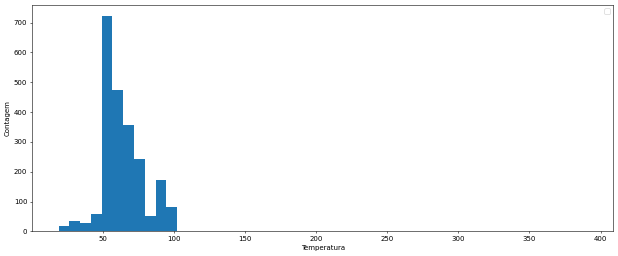

In [ ]:
temperaturas = dataset.to_numpy()
temperaturas = temperaturas[:,3:4]
bins = np.linspace(temperaturas.min(), temperaturas.max(), 50)
plt.figure(figsize=(15, 6), dpi=50)
plt.hist(temperaturas, bins=bins)
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

Text(0.5, 0, 'Temperatura')

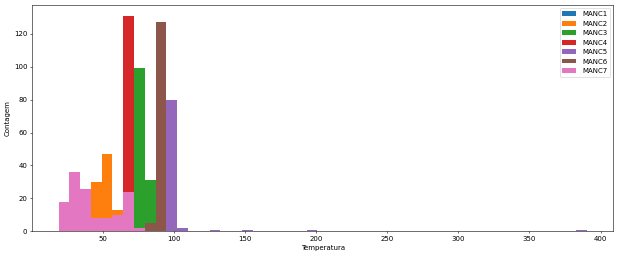

In [ ]:
tempsManc1 = manc1.to_numpy()[:,3:4]
tempsManc2 = manc2.to_numpy()[:,3:4]
tempsManc3 = manc3.to_numpy()[:,3:4]
tempsManc4 = manc4.to_numpy()[:,3:4]
tempsManc5 = manc5.to_numpy()[:,3:4]
tempsManc6 = manc6.to_numpy()[:,3:4]
tempsManc7 = manc7.to_numpy()[:,3:4]

plt.figure(figsize=(15, 6), dpi=50)
plt.hist(tempsManc1, bins=bins, label='MANC1')
plt.hist(tempsManc2, bins=bins, label='MANC2')
plt.hist(tempsManc3, bins=bins, label='MANC3')
plt.hist(tempsManc4, bins=bins, label='MANC4')
plt.hist(tempsManc5, bins=bins, label='MANC5')
plt.hist(tempsManc6, bins=bins, label='MANC6')
plt.hist(tempsManc7, bins=bins, label='MANC7')
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

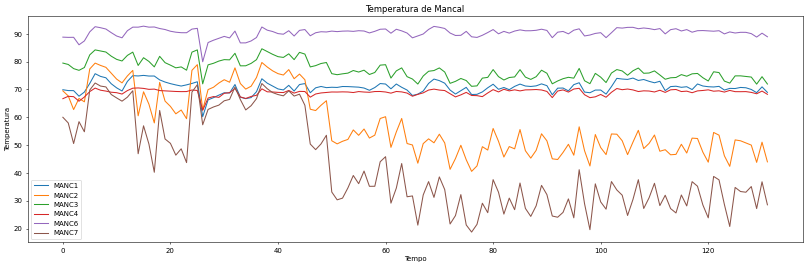

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(tempsManc1, label='MANC1')
plt.plot(tempsManc2, label='MANC2')
plt.plot(tempsManc3, label='MANC3')
plt.plot(tempsManc4, label='MANC4')
#plt.plot(tempsManc5, label='MANC5')
plt.plot(tempsManc6, label='MANC6')
plt.plot(tempsManc7, label='MANC7')

plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.legend()
plt.show()

## Parte 2 - Preprocessamento de Dados

### Separação do conjunto de Treino e Teste

In [ ]:
datasetMancal = manc3
#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
#datasetMancal = datasetMancal.astype({"TEMPERATURA": int})
#datasetMancal['TEMPERATURA'] = datasetMancal['TEMPERATURA'].round(decimals=1)

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(datasetMancal)*0.7)
test_size  = len(datasetMancal) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = datasetMancal.iloc[0:train_size, 3:4].values
test_set  = datasetMancal.iloc[train_size:(train_size + test_size), 3:4].values

### gráfico da série temporal

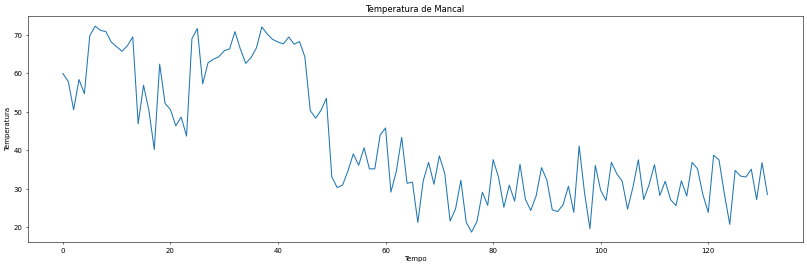

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(datasetMancal.iloc[0:len(datasetMancal), 3:4].values)
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [ ]:
def prepareSetRN(windowSize, outputSize, flatSet ):
    preparedX = []
    preparedY = []
    setSize = len(flatSet)
    for i in range(windowSize, setSize - (outputSize-1)):
        preparedX.append(flatSet[i-window:i, 0])
        preparedY.append(flatSet[i:i + output_size, 0])

    preparedX, preparedY = np.array(preparedX), np.array(preparedY)
    return preparedX, preparedY

window      = 3
output_size = 3
layers      = 3
unitSet     = [120,60,40]
dropout     = 0.2 
optmizer    = 'Adam'
epochs      = 1000
batch_size  = 32

X_train = []
y_train = []
X_train, y_train = prepareSetRN(window, output_size, training_set_scaled)

### Reshaping

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Parte 3 - Construção da RNN

### Construção da Rede completa

In [ ]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = unitSet[0], return_sequences = (layers > 1), input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(dropout))
 
# Adicionar a segunda camada LSTM e Dropout
if ( layers >= 2 ):
  regressor.add(LSTM(units = unitSet[1], return_sequences = (layers > 2)))
  regressor.add(Dropout(dropout))
 
# Adicionar a terceira camada LSTM e Dropout
if ( layers >= 3 ):
  regressor.add(LSTM(units = unitSet[2], return_sequences = (layers > 3)))
  regressor.add(Dropout(dropout))

# camada de saída
regressor.add(Dense(units = output_size, activation='linear'))
#Testar sigmoid e linear

# Compilar a rede
regressor.compile(optimizer = optmizer, loss = 'mean_squared_error', metrics=['accuracy'])

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 120)            58560     
_________________________________________________________________
dropout (Dropout)            (None, 3, 120)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 60)             43440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 60)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                16160     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

### Treinamento

In [ ]:
history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/1000
3/3 [==============================] - 19s 9ms/step - loss: 0.3934 - accuracy: 0.3232
Epoch 2/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3555 - accuracy: 0.3519
Epoch 3/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3181 - accuracy: 0.3736
Epoch 4/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.2829 - accuracy: 0.3597
Epoch 5/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.2057 - accuracy: 0.3540
Epoch 6/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.1542 - accuracy: 0.3675
Epoch 7/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0927 - accuracy: 0.3597
Epoch 8/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0577 - accuracy: 0.3402
Epoch 9/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0827 - accuracy: 0.3867
Epoch 10/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.3093
Epoch 11/1000
3/3 

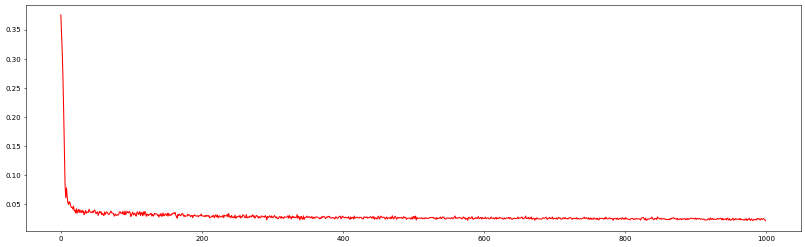

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['loss'], color = 'red', label = 'Loss')

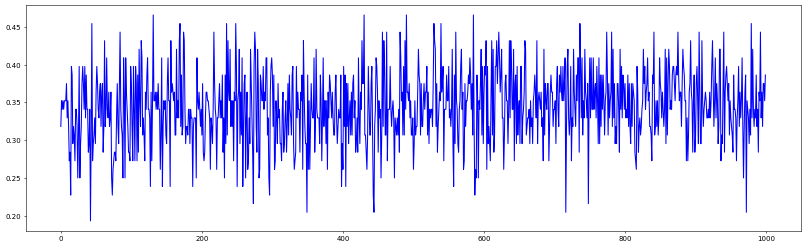

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')

## Parte 4 - Fazer as previsões e analisar os resultados

### Base de teste

### Construir a estrutura para teste

In [ ]:
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 3:4].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output_size, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [ ]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    #Adiciona as primeiras colunas do primeiro registro quando a janela > 1
    if window_size > 1:
      for i in range(0, window_size-1):
        flatSet.append(windowSet[0, i])

    for i in range(0, setSize):
        flatSet.append(windowSet[i, window_size-1])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

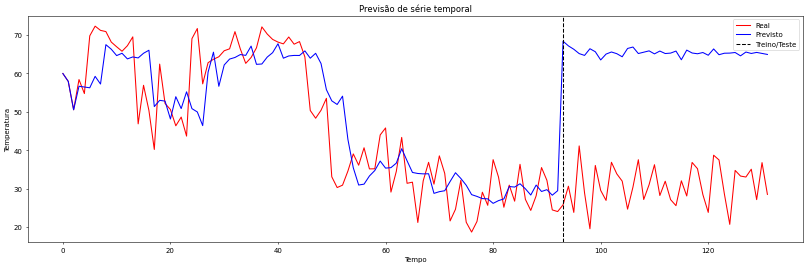

In [33]:
#allTargetData = np.vstack((test_set))
#allForecastedData = np.vstack((test_predicted))
allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_predicted))

plt.figure(figsize=(20, 6), dpi=50)
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.axvline(x=len(train_set), label='Treino/Teste', c='k',ls='--')

plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

In [ ]:
for i in range(0, 20):
  print( allTargetData[i], allForecastedData[i])

[25.79558] [68.396355]
[30.65408] [67.176186]
[23.83858] [66.29832]
[41.14117] [65.16863]
[28.90278] [64.697914]
[19.57737] [66.435905]
[36.05653] [65.65438]
[29.56197] [63.51613]
[26.95031] [65.0436]
[36.88075] [65.5885]
[33.85757] [65.143875]
[31.97517] [64.34485]
[24.6848] [66.50487]
[30.43175] [66.878365]
[37.54445] [65.187004]
[27.19311] [65.547226]
[31.053] [65.88053]
[36.25079] [65.09785]
[28.23553] [65.83168]
[31.95515] [65.18821]


## Parte 5 - Métricas de avaliação

In [ ]:
rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
print('RMSE: ', rmse)

RMSE:  35.0095203426951


In [ ]:
mse = mean_squared_error(test_set, test_predicted)
print('MSE: ',mse)

MSE:  1225.6665146255816


In [ ]:
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100
print('MAPE: ',mape, '%')

MAPE:  118.49904856631672 %
